<h1><center>«Portfolio-Exam Part I» </center></h1>
<h2><center>MADS-SMA </center></h2>
<h3><center>Author: Tom Wüsten </center></h3>

### Introduction
This paper deals about the evaluation from different approaches of sentiment analysis. The basis for this is a dataset of restaurant reviews from the yelp platform. The reviews are in English and rate restaurants in Hamburg. The rating is done by stars from 1-5, where 5 stars is the best rating. At the beginning, information about the data set will be gathered in the data exploration, which will be used for the pre-processing of the data. Based on this a Sentiment analysis will compare classic approaches like Bag of Words with newer approaches like Transformer. Furthermore, it will be discussed which methods can be used to train Transformer from the platform Huggingface on own data.

In [2]:
# Load libaries
import pandas as pd
import numpy as np
from transformers import pipeline
from langdetect import detect
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import warnings
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from helper.normalize_documents import normalize_document

warnings.filterwarnings("ignore")

The provided dataset of yelp has the url, stars of the rating, text-based rating and the date of the raing as columns.

In [3]:
yelp_reviews = pd.read_csv("data/yelp_reviews_hamburg_en.csv")
yelp_reviews.head()

,url,stars,text,date
0,https://www.yelp.com/biz/il-buco-hamburg,5.0,Fantastic little restaurant!Great staff and fo...,2017-08-12
1,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,We went there to grab some breakfast. They are...,2015-09-29
2,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,"Good coffee, sandwiches, and yogurts close t...",2016-01-13
3,https://www.yelp.com/biz/campus-suite-hamburg-7,3.0,When XING handed out coupons for free coffee d...,2008-04-24
4,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,I love Campus Suite franchise. after the Balza...,2010-01-15


In [4]:
yelp_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   url     3025 non-null   object 
 1   stars   3025 non-null   float64
 2   text    3025 non-null   object 
 3   date    3025 non-null   object 
dtypes: float64(1), object(3)
memory usage: 94.7+ KB


In [5]:
yelp_reviews.describe()

,stars
count,3025.000000
mean,4.076033
std,1.094798
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000


In [6]:
yelp_reviews.shape

(3025, 4)

To check the data, duplicates are filtered and missing values are checked. The result shows that there are no duplicates and no missing values in the dataset.

In [7]:
# Checking duplicates rows
duplicateRows = yelp_reviews[yelp_reviews.duplicated()]
# CHecking na values
na_values = yelp_reviews.isnull().sum().sum()
print(f"The dataset has {duplicateRows.shape[0]} duplicates and has {na_values} nan values.")

The dataset has 0 duplicates and has 0 nan values.


### Data Exploration
In the data analysis we want to get a picture of how the data is distributed. For this purpose, we want to look at the structure of the ratings and give an overview of the period in which the comments were created. <br>
Based on the first graph, we can see that the ratings of the restaurants are often good. The most votes have received 5 & 4 stars. It is remarkable that there are few bad ratings. <br>
In the second plot, we examine the text length of the comments. Most of the comments are in the range between 100 words.

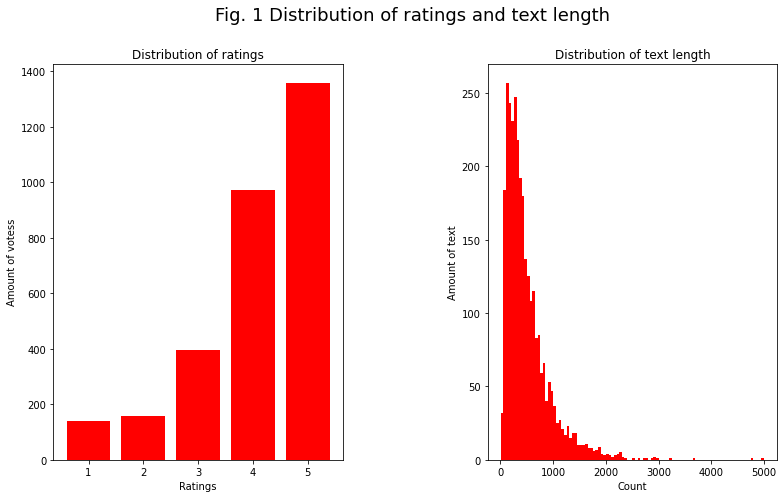

In [8]:
yelp_reviews_ratings = yelp_reviews.groupby("stars").agg("count").reset_index()
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.5, wspace=0.5, hspace=None)
fig.suptitle(
    "Fig. 1 Distribution of ratings and text length",
    horizontalalignment="left",
    y=fig.subplotpars.right - 00.1,
    fontsize=18,
)
ax[0].bar(yelp_reviews_ratings.stars, yelp_reviews_ratings.url, color="r")
# Bar Plot
ax[0].set_ylabel("Amount of votess")
ax[0].set_xlabel("Ratings")
ax[0].set_title("Distribution of ratings")
# 2. Plot
yelp_reviews["amount_text"] = yelp_reviews["text"].apply(lambda x: sum(word in x for word in x))

ax[1].hist(yelp_reviews["amount_text"], bins=100, color="r")
# Bar Plot
ax[1].set_ylabel("Amount of text")
ax[1].set_xlabel("Count")
ax[1].set_title("Distribution of text length")
# Save figure
plt.savefig("output/distribution_text_rating", bbox_inches="tight")
# Show Plot

plt.show()

The plot below examines when comments have been written. The dataset includes ratings from 2006 to 2022, with the majority of ratings from 2015 & 2016. Furthermore, it can be seen that the months do not have a large influence on the visits. There is only a drop in ratings in November and December.

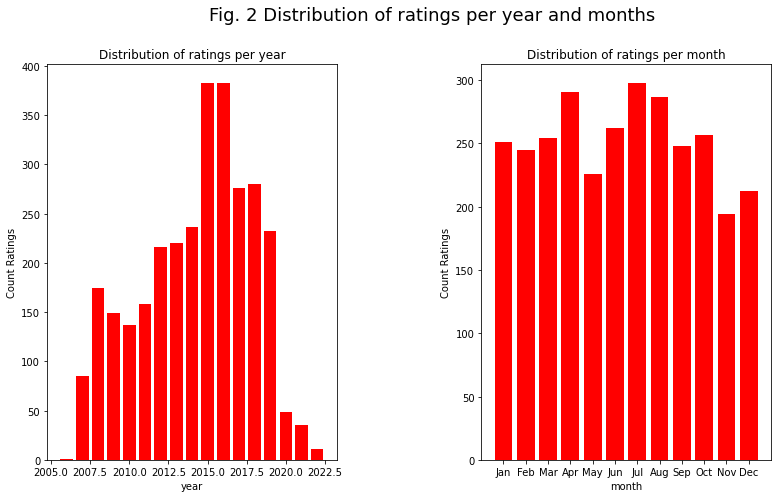

In [9]:
yelp_reviews["date"] = pd.to_datetime(yelp_reviews["date"])
yelp_reviews["year"] = yelp_reviews["date"].dt.year
yelp_reviews["month"] = yelp_reviews["date"].dt.strftime("%b")
yelp_reviews["weekday"] = yelp_reviews["date"].dt.strftime("%a")
year = yelp_reviews.groupby("year", as_index=False).agg(Count_stars=("stars", "count"))
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.5, wspace=0.5, hspace=None)
fig.suptitle(
    "Fig. 2 Distribution of ratings per year and months",
    horizontalalignment="left",
    y=fig.subplotpars.right - 00.1,
    fontsize=18,
)
ax[0].bar(year["year"], year["Count_stars"], color="r")
# Bar Plot
ax[0].set_ylabel("Count Ratings")
ax[0].set_xlabel("year")
ax[0].set_title("Distribution of ratings per year")
# 2. Plot
month = yelp_reviews.groupby([yelp_reviews["date"].dt.strftime("%m"), "month"], as_index=False).agg(
    Count_stars=("stars", "count")
)
ax[1].bar(month["month"], month["Count_stars"], color="r")
# Bar Plot
ax[1].set_ylabel("Count Ratings")
ax[1].set_xlabel("month")
ax[1].set_title("Distribution of ratings per month")
# Save figure
plt.savefig("output/distribution_rating_year_month", bbox_inches="tight")
# Show Plot
plt.show()

## Pre-Processing
At the preprocessing we want to get grid of useless data and want to check our data and bring oit also in a better form for our models. <br>
The first step is to check the language. As a starting point, the data set from yelp was taken, which contains English restaurant reviews. To achieve better results in our ratings, it is important that the language is the same. It turns out that 85 comments are not written in English. Most of the 85 comments are in English. In the further course, it will be shown which other languages are also present in the comments.

In [10]:
yelp_reviews["language"] = yelp_reviews["text"].apply(lambda x: detect(x))
yelp_reviews[yelp_reviews["language"] != "en"].head()

,url,stars,text,date,amount_text,year,month,weekday,language
44,https://www.yelp.com/biz/cafe-strauss-hamburg,5.0,Wir waren erneut zum Frühstück unter der Woche...,2013-08-27,167,2013,Aug,Tue,de
65,https://www.yelp.com/biz/kumpir-hamburg-6,5.0,Gaaaanz lecker und preiswert!!!! Ich stimme zu...,2011-08-24,161,2011,Aug,Wed,de
66,https://www.yelp.com/biz/kumpir-hamburg-6,5.0,Absoluter Fan. Standard bei mir Habibi mit Hüh...,2013-03-03,134,2013,Mar,Sun,de
70,https://www.yelp.com/biz/kumpir-hamburg-6,5.0,"Für preiswerte 3,70EUR gibt es hier eine Mahlz...",2011-12-03,549,2011,Dec,Sat,de
96,https://www.yelp.com/biz/chakra-caf%C3%A9-hamb...,4.0,"ruehrei war lecker, orientalisches Fruehstueck...",2012-11-08,80,2012,Nov,Thu,de


The evaluation of the languages shows that the data set also includes other languages such as German, French, danish, dutch, norweign or Spanish.

In [11]:
yelp_reviews[yelp_reviews["language"] != "en"]["language"].value_counts()

de    76
fr     5
lt     1
da     1
es     1
Name: language, dtype: int64

Our later models can only make good predictions of sentiment for one language, so we need to remove non-English comments.

In [12]:
yelp_reviews_en = yelp_reviews[yelp_reviews["language"] == "en"]

In [13]:
evaluation_df = pd.DataFrame(
    {
        "model": [],
        "accuracy": [],
        "confusion matrix": [],
    }
)

## Transformer Model
The first model is to be created on the basis of a transformer. For this purpose, a model from Huggingface is used, which was trained on the basis of ratings and determines sentiments from 1-5. First, it will be investigated how well a model performs without FineTuning. The model is based on Bert and is multilingual. It supports the languages English, German, Dutch, French, Italian and Spanish. The developers state an accuracy of 67% for the English language. In this model, I would like to compare how the comments from English only differ from the mixed data set.

In [14]:
sentiment_pipeline = pipeline(
    "sentiment-analysis", "nlptown/bert-base-multilingual-uncased-sentiment"
)

The Config can be used to obtain information about the model. The Bert model has 5 labels as output and a BertForSequenceClassification architecture. The output is a string that evaluates the rating based on "1 star" -> 1.

In [15]:
print(sentiment_pipeline.model.config)

BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_to

To get a better overview of the Tokenizer, you can display the Tokenizer. You will notice that the model may have a maximum of 512 characters as input. This means that the data we can use for the experiment is significantly smaller.

In [16]:
sentiment_pipeline.tokenizer

PreTrainedTokenizerFast(name_or_path='nlptown/bert-base-multilingual-uncased-sentiment', vocab_size=105879, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

After adjusting the maximum length of comments to 512 characters, the data set has dropped to 1929. Compared to the initial data set, we can only use 60% of the data.

In [17]:
yelp_reviews = yelp_reviews[yelp_reviews["amount_text"] <= 512]
print(f"The dataset contains now {yelp_reviews.shape[0]} samples.")
yelp_reviews_en = yelp_reviews_en[yelp_reviews_en["amount_text"] <= 512]
print(f"The english dataset contains now {yelp_reviews_en.shape[0]} samples.")

The dataset contains now 1929 samples.
The english dataset contains now 1862 samples.


In the next step, we use Huggingface's pipeline to create the sentiments based on the transformer. This is first done with the entire dataset.

In [18]:
yelp_reviews["rating"] = yelp_reviews["text"].apply(lambda x: sentiment_pipeline(x)[0].get("label"))
yelp_reviews["rating"] = yelp_reviews["rating"].apply(lambda x: int(x[0]))
yelp_reviews = yelp_reviews.astype({"stars": int})

In the next step we create the Accuracy and Confusion matrix and save the result. The results are compared at the end of this chapter.

In [19]:
acc_score = accuracy_score(yelp_reviews["stars"], yelp_reviews["rating"])
cm = confusion_matrix(yelp_reviews["stars"], yelp_reviews["rating"], labels=[1, 2, 3, 4, 5])
evaluation_df = evaluation_df.append(
    pd.DataFrame({"model": ["Transformer"], "accuracy": [acc_score], "confusion matrix": [cm]})
)

We now perform the same procedure for the English data set.

In [20]:
yelp_reviews_en["rating"] = yelp_reviews_en["text"].apply(
    lambda x: sentiment_pipeline(x)[0].get("label")
)
yelp_reviews_en["rating"] = yelp_reviews_en["rating"].apply(lambda x: int(x[0]))
yelp_reviews_en = yelp_reviews_en.astype({"stars": int})
acc_score = accuracy_score(yelp_reviews_en["stars"], yelp_reviews_en["rating"])
cm = confusion_matrix(yelp_reviews_en["stars"], yelp_reviews_en["rating"], labels=[1, 2, 3, 4, 5])
evaluation_df = evaluation_df.append(
    pd.DataFrame({"model": ["Transformer EN"], "accuracy": [acc_score], "confusion matrix": [cm]})
)

In the Confusiomatrix plot shown below, the two approaches are compared. On the left side is the plot with the whole dataset and on the right side the dataset that has English-only comments. The accuracy of both models is very similar, with the model with the mixed language dataset performing 0.01% better than the English-only dataset. The multi-lingual dataset achieved an accuracy of 0.63 and the English-only dataset an accuracy of 0.62. Since the Transformer is multilinual, it makes sense that it performed a bit better because it thus had more data. <br>
From both confusion matrices, it can be seen that most of the deviation is around one rating point.

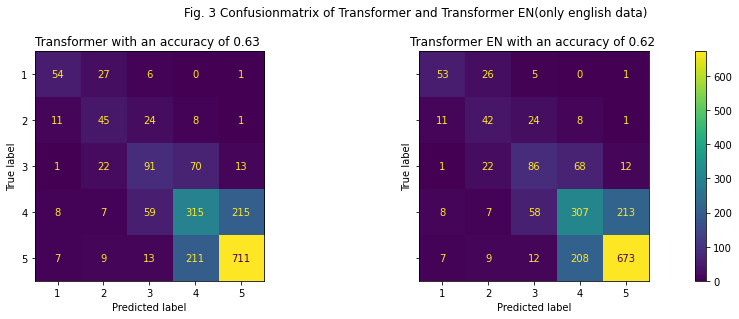

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2.5), sharey="row")
plt.subplots_adjust(left=None, bottom=None, right=1.4, top=1.4, wspace=0.1, hspace=None)
fig.suptitle(
    "Fig. 3 Confusionmatrix of Transformer and Transformer EN(only english data)",
    horizontalalignment="left",
    y=1.65,
    fontsize=12,
)
labels = [1, 2, 3, 4, 5]
for i in range(2):
    disp = ConfusionMatrixDisplay(confusion_matrix=evaluation_df.iloc[i, 2], display_labels=labels)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(
        f"{evaluation_df.iloc[i,0]} with an accuracy of {round(evaluation_df.iloc[i,1],2)} "
    )
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel("Predicted label")

# f.text(0.4, 0.1, 'Predicted label', ha='left')
# plt.subplots_adjust(wspace=0.40, hspace=0.1)
# Save figure
plt.savefig("output/conf_transformer", bbox_inches="tight")

fig.colorbar(disp.im_, ax=axes)
plt.show()

### Fine-Tuned Model with Hugging Face

The next step is to train the output transformer "nlptown/bert-base-multilingual-uncased-sentiment" on our data. Before we can do that, we need to do some pre-processing steps. For this we need to create a training data set, a validation set and a test set. Since the Transformer has an internal rating system of 0-4, we have to adjust the stars.

In [22]:
yelp_reviews = pd.read_csv("data/yelp_reviews_hamburg_en.csv")
yelp_reviews = yelp_reviews.astype({"stars": int})
yelp_reviews["stars"] = yelp_reviews["stars"].apply(lambda x: x - 1)

The next step is to create a split between training, validation and test data using SKlearn. The validation data set is 20% of the general data set. Furthermore, we only need the text and the rating. Then we save the data in a CSV file so that we can work with it more easily later.

In [23]:
train_df, test_df = train_test_split(yelp_reviews, test_size=0.2, random_state=42)
train, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
val_df = val_df[["stars", "text"]]
train = train[["stars", "text"]]
test_df = test_df[["stars", "text"]]
train.to_csv("data/train.csv", index=False)
val_df.to_csv("data/val.csv", index=False)
train.shape, val_df.shape, test_df.shape

((1936, 2), (484, 2), (605, 2))

With the help of the Huggingface Dataset library, we can load the data from the Csv file and put it directly into a certain format, which will help us to better train our transformer later on.

In [24]:
dataset = load_dataset("csv", data_files={"train": "data/train.csv", "test": "data/val.csv"})

Using custom data configuration default-093667f63ea0a2ab


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to C:\Users\wuest\.cache\huggingface\datasets\csv\default-093667f63ea0a2ab\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

The function `tokenize_function` uses the tokenizer of the model "nlptown/bert-base-multilingual-uncased-sentiment" to convert the words into tokens. Using the paramter padding we can determine the maximum length of the input words. We have already seen from the previous experiment that this is 512 words.

In [25]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")


def tokenize_function(text):
    return tokenizer(text["text"], padding="max_length", truncation=True)

With the help of the `tokenize_function`, the whole data set is converted into tokens. As further steps, columns are renamed or removed to match the output transformer. The last step is to split the data set into training data and validation data.

In [26]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("stars", "labels")
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)
small_train_dataset = small_train_dataset.remove_columns(["token_type_ids"])
small_eval_dataset = small_eval_dataset.remove_columns(["token_type_ids"])

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [27]:
small_train_dataset["input_ids"].size(), small_eval_dataset["input_ids"].size()

(torch.Size([1936, 512]), torch.Size([484, 512]))

As a basis for customizing the transformer, we download the transformer "nlptown/bert-base-multilingual-uncased-sentiment" from Huggingface.

In [28]:
model = AutoModelForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment"
)

Hugginface provides a trainer and TrainingArgument. The TrainingArgument is used to define how the training takes place. In my case I limited the training to 3 epochs because the training takes a long time. 3 epochs of training take 5 hours on my laptop. Furthermore batches have to be defined, which have to be as small as possible, because they are directly related to the RAM. With my computer of 16GB RAM a maximum batch size of 8 was possible.

In [29]:
training_args = TrainingArguments(
    output_dir="./sentiment-analysis",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    save_strategy="epoch",
    evaluation_strategy="steps",
)

The next step is to determine by which metric the model should be optimized. Since we want to achieve the highest possible accuracy, accuracy was used as the metric.

In [30]:
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

The trainer library of hugginface takes all parameters that are important for the fine tuning of the model as input. It uses the initial model, the training arguments, the training and validation dataset and the metric on which the model should be optimized.

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In this step, the model is trained and fine-tuned to the dataset from yelp. After training, Huggingface will reflect the results for each epoch. The last model is always the best model, because it has the lowest loss. Since the model is stored locally, you can not share with other people. The training of three epochs takes 5h. Therefore is commented out.

In [32]:
# trainer.train()
# tokenizer.save_pretrained("./sentiment-analysis\checkpoint-303")

After fine-tuning the pre-trained model we can upload to the huggingface hub. This has the advantage that we can easily share the large amount of data with other people. Huggingface takes care of the storage of the large models. My local fine tuned model has a memory size of 2GB. Huggingface creates a Git repo for this, which anyone else can download immediately.

In [33]:
# tokenizer.push_to_hub("sentiment-analysis-fh-kiel")
# model.push_to_hub("sentiment-analysis-fh-kiel")

After uploading our fine tunded model to Huggingface, we can download the model from Huggingface in the same way as the first experiment.

In [34]:
my_model_from_hub = AutoModelForSequenceClassification.from_pretrained(
    "wuesten/sentiment-analysis-fh-kiel"
)
my_tokenizer = AutoTokenizer.from_pretrained("wuesten/sentiment-analysis-fh-kiel")

loading configuration file https://huggingface.co/wuesten/sentiment-analysis-fh-kiel/resolve/main/config.json from cache at C:\Users\wuest/.cache\huggingface\transformers\69724c75ebe2d0a526b8206aba241eb25e6315a6a13501cab3f7893a6b23b6e1.4d7c9cb2ebe7ef2468ec93f4b3f4fefae4cb1236fe17d900d80b1e8d07a5ed75
Model config BertConfig {
  "_name_or_path": "wuesten/sentiment-analysis-fh-kiel",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "ma

Now we can build a pipeline for prediction again. To do this, we load the model and our tokeniser into the pipeline in order to carry out an evaluation on our test data.

In [35]:
sentiment_pipeline_2 = pipeline("sentiment-analysis", my_model_from_hub, tokenizer=my_tokenizer)

The next steps are again similar to the first experiment. First we create labels that predict the model and then we build the accuracy and the confusion matrix.

In [36]:
test_df["amount_text"] = test_df["text"].apply(lambda x: sum(word in x for word in x))
test_df = test_df[test_df["amount_text"] <= 512]
test_df["rating"] = test_df["text"].apply(lambda x: sentiment_pipeline_2(x)[0].get("label"))
test_df["rating"] = test_df["rating"].apply(lambda x: int(x[0]))
test_df = test_df.astype({"stars": int})
acc_score = accuracy_score(test_df["stars"] + 1, test_df["rating"])
labels = [1, 2, 3, 4, 5]
cm = confusion_matrix(test_df["stars"] + 1, test_df["rating"], labels=labels)
evaluation_df = evaluation_df.append(
    pd.DataFrame(
        {"model": ["fine-tuned Transformer"], "accuracy": [acc_score], "confusion matrix": [cm]}
    )
)

The result of our fine tuned model achieves a significantly better accuracy of 0.8, which is an increase of 0.18.

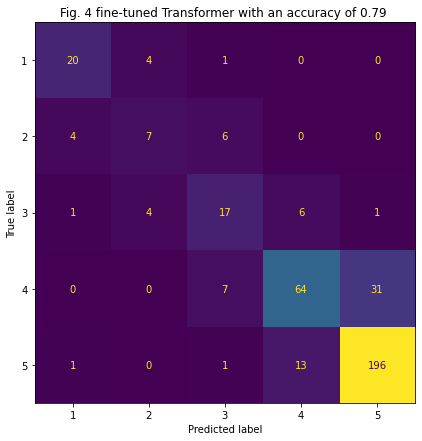

In [37]:
fig = plt.figure(figsize=(15, 7))
labels = [1, 2, 3, 4, 5]
ax = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=evaluation_df.iloc[2, 2], display_labels=labels)
disp.plot(ax=ax)
disp.ax_.set_title(
    f"Fig. 4 {evaluation_df.iloc[2,0]} with an accuracy of {round(evaluation_df.iloc[2,1],2)} "
)
disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.60, hspace=0.1)
# Save figure
plt.savefig("output/conf_fine_tuned_transformer", bbox_inches="tight")

fig.colorbar(disp.im_, ax=axes)
plt.show()

### Bag of Words vs TF-ID
After we have examined Transformers, I would like to end by evaluating classic sentiment analyses. For this purpose I have chosen Bag of Words and TF-ID.Pre-proccesing is the same for both approaches. First, a corpus is created based on the yelp data and the stop words are deleted. As a next step, punctuation marks and special characters are removed and the words are converted to lowercase. This done thorugh `normalize_document` function.

In [38]:
# Create corpus
corpus = []
for i in range(yelp_reviews.shape[0]):
    corpus.append(yelp_reviews.iloc[i][2])
normalize_corpus = np.vectorize(normalize_document)
normalized_corpus = normalize_corpus(corpus)

#### Bag of words
To create a Bag of Words, we take the Corpus and use the CountVectorizer. To compare the results later we used a training test split. 


In [39]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(normalized_corpus).toarray()
y = yelp_reviews["stars"].values + 1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

#### Comparison of classifier for Bag of words

Based on the Bag of Words, different classifiers can now be compared with each other. For this purpose, a Gaussian Naive Bayes, linear regression and a random forest algorithm have been selected.

In [40]:
clf_gauss = GaussianNB()
clf_gauss.fit(X_train, y_train)
y_pred = clf_gauss.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5])
evaluation_df = evaluation_df.append(
    pd.DataFrame(
        {"model": ["Bag of words: GaussianNB"], "accuracy": [acc_score], "confusion matrix": [cm]}
    )
)

In [41]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
acc_score = accuracy_score(y_test, y_pred.round())
cm = confusion_matrix(y_test, y_pred.round(), labels=[1, 2, 3, 4, 5])
evaluation_df = evaluation_df.append(
    pd.DataFrame(
        {"model": ["Bag of words: linear Reg."], "accuracy": [acc_score], "confusion matrix": [cm]}
    )
)

In [42]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred.round(), labels=[1, 2, 3, 4, 5])
evaluation_df = evaluation_df.append(
    pd.DataFrame(
        {"model": ["Bag of words: RandomForest"], "accuracy": [acc_score], "confusion matrix": [cm]}
    )
)

#### TF-ID

In [43]:
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(normalized_corpus).toarray()
y = yelp_reviews["stars"].values + 1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

#### Comparison of classifier TF-ID

In [44]:
clf_gauss = GaussianNB()
clf_gauss.fit(X_train, y_train)
y_pred = clf_gauss.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5])
evaluation_df = evaluation_df.append(
    pd.DataFrame(
        {"model": ["TF-ID: GaussianNB"], "accuracy": [acc_score], "confusion matrix": [cm]}
    )
)

In [45]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
acc_score = accuracy_score(y_test, y_pred.round())
cm = confusion_matrix(y_test, y_pred.round(), labels=[1, 2, 3, 4, 5])
evaluation_df = evaluation_df.append(
    pd.DataFrame(
        {"model": ["TF-ID: linear Reg."], "accuracy": [acc_score], "confusion matrix": [cm]}
    )
)

In [46]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5])
evaluation_df = evaluation_df.append(
    pd.DataFrame(
        {"model": ["TF-ID: RandomForest"], "accuracy": [acc_score], "confusion matrix": [cm]}
    )
)

### Evaluation

In this sentiment analysis, different approaches from Transformer to Bag of Words and TF-ID have been shown. It is not surprising that the transformers that have been trained on very large data sets perform better. Furthermore, a fine tuning of one transformer resulted in a significant increase from 63% to 80% acccuracy. It can be assumed that an improvement through longer fine tuning would show even better results. But due to limited hardware, I could only do 3 epochs, which took 6 hours. <br>
The TF-ID and Bag of Words approaches produced similar results for the same classifiers. The exception is linear regression, because it performed much better with TF-ID. The best results were achieved with the random forest classifier. With TF-ID 51.2% and with Bag of words 52.6% accuracy was achieved.


In [47]:
evaluation_df

,model,accuracy,confusion matrix
0,Transformer,0.630378,"[[54, 27, 6, 0, 1], [11, 45, 24, 8, 1], [1, 22..."
0,Transformer EN,0.623523,"[[53, 26, 5, 0, 1], [11, 42, 24, 8, 1], [1, 22..."
0,fine-tuned Transformer,0.791667,"[[20, 4, 1, 0, 0], [4, 7, 6, 0, 0], [1, 4, 17,..."
0,Bag of words: GaussianNB,0.365289,"[[2, 5, 5, 10, 12], [0, 0, 6, 10, 6], [3, 6, 1..."
0,Bag of words: linear Reg.,0.320661,"[[4, 9, 7, 9, 2], [3, 4, 8, 2, 0], [5, 13, 18,..."
0,Bag of words: RandomForest,0.525620,"[[5, 0, 2, 8, 19], [1, 0, 0, 14, 7], [1, 0, 3,..."
0,TF-ID: GaussianNB,0.370248,"[[1, 5, 4, 9, 15], [0, 0, 6, 9, 7], [3, 6, 12,..."
0,TF-ID: linear Reg.,0.438017,"[[4, 7, 15, 7, 1], [3, 6, 10, 3, 0], [2, 7, 29..."
0,TF-ID: RandomForest,0.519008,"[[1, 0, 0, 5, 28], [1, 0, 2, 11, 8], [0, 0, 2,..."


Finally, all experiments are presented in a Confusion Matrix. In general the size of the test data is always the same with one exception for the pre-trained transformers, as they were already trained.  With the transformers, it can be seen that the deviation is often only 1 to the correct value. This is already a very good result. With the fine tuned transformer, the deviation in the lower ratings is very small. Most deviations can be seen in the rating of 4.  <br>
The experiments of Bag of Words have performed very badly on labels with a poor rating. This could be because there are few poorly rated labels. The Random Forest from the accurary performed best, but this is only due to the fact that it almost always had a prediction of 5. <br>
TF-ID's experiments performed very similarly to Bag of Words. In general, it can be seen that low scores are not well recognised. Classifiers that predict high ratings across the board could achieve higher accuracy because the dataset contains more good ratings.

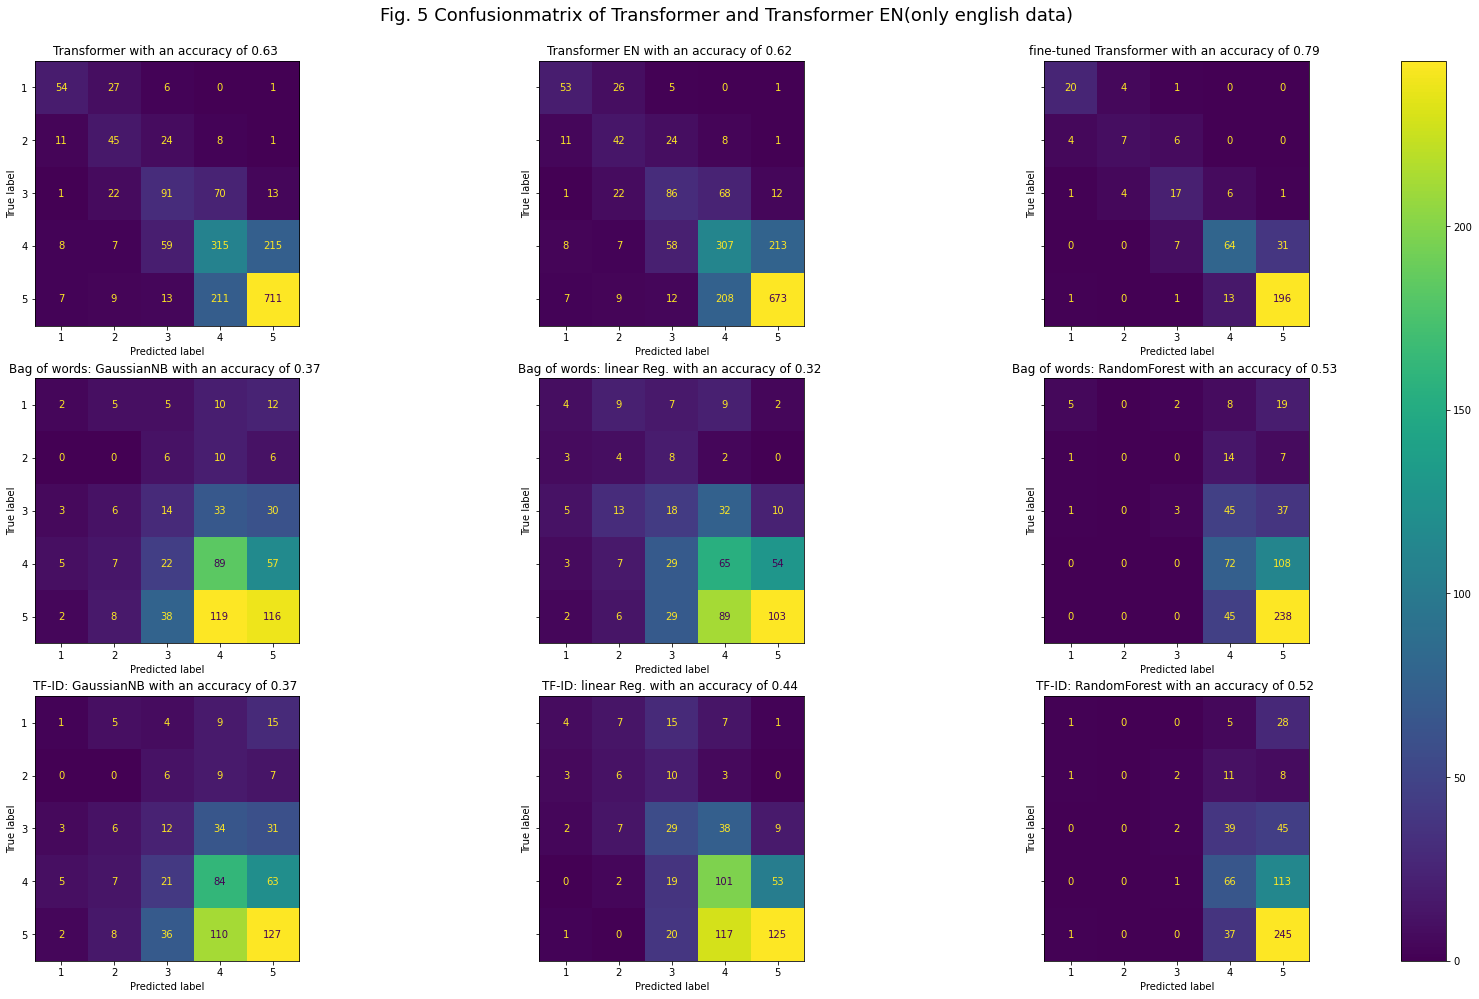

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(20, 5), sharey="row")
axes = axes.flatten()
plt.subplots_adjust(left=None, bottom=-1, right=1.4, top=1.5, wspace=0.1, hspace=None)
fig.suptitle(
    "Fig. 5 Confusionmatrix of Transformer and Transformer EN(only english data)",
    horizontalalignment="left",
    y=1.65,
    fontsize=18,
)
labels = [1, 2, 3, 4, 5]
for i in range(9):
    disp = ConfusionMatrixDisplay(confusion_matrix=evaluation_df.iloc[i, 2], display_labels=labels)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(
        f"{evaluation_df.iloc[i,0]} with an accuracy of {round(evaluation_df.iloc[i,1],2)} "
    )
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel("Predicted label")
    # disp.ax_.set_ylabel('True label')

# f.text(0.4, 0.1, 'Predicted label', ha='left')
# plt.subplots_adjust(wspace=0.40, hspace=0.1)
# Save figure
plt.savefig("output/conf_overview", bbox_inches="tight")

fig.colorbar(disp.im_, ax=axes)
plt.show()

### Outlook

Based on the sentiment analysis, it could be shown that a text classification is well possible. It was found that classifiers often scored very high on Bag of Words and TF-ID. This is due to the fact that the data set is not balanced and for the most part there are good ratings. This could be improved by adjusting the data set or by using methods such as SMOTE to oversample the data set. This would make the model better at predicting low ratings. <br>
The fine tuned Transformer finished best. This could still be improved by longer training. This could be achieved by training the model in a cloud, because the hardware of laptops is very limited compared to the resources needed to train huge neural networks.
